In [1]:
import pickle
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import numpy as np
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
def pick_first(loaded_list):
    new_list = []
    for item in loaded_list:
        try:
            number = int(item[0])
            new_list.append(number)
        except:
            new_list.append(-1)
    return new_list

def dicom_image_to_np(filepath): # this one is for simple preprocess
    dcm = pydicom.dcmread(filepath)
    image_data = dcm.pixel_array
    resized_image = cv2.resize(image_data, (256,256)) 
    normalized_image = resized_image / 255.0
    return np.array(normalized_image)

def cover_sides(img, cover_width=50):
    if cover_width < 0 or cover_width > img.shape[1] // 2:
        raise ValueError("cover_width must be between 0 and half of the image width.")
    
    modified_img = img.copy()
    modified_img[:, :cover_width] = 0 
    modified_img[:, -cover_width:] = 0  
    
    return modified_img

def draw_CR(image_data):
    
    plt.imshow(image_data, cmap='gray') 
    plt.axis('off')
    plt.show()

In [3]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    if image.dtype != np.uint8:
        image = np.uint8(image)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

# Gaussian Blur
def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

# Median Filtering
def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def enhance_image_signal(image):
    if image.dtype != np.uint8:
        image = np.uint8(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    return blurred_image

def apply_rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [4]:
with open('./data/zip_lists_9968.pkl', 'rb') as f:
    zip_load_list = pickle.load(f)

with open('./data/image_lists_9968.pkl', 'rb') as f:
    image_load_list = pickle.load(f)

In [5]:
zip_filt_list = pick_first(zip_load_list)

In [6]:
zip_list = []
image_list = []
for i in range(len(zip_filt_list)):
    if zip_filt_list[i] == 4 or zip_filt_list[i] == 9 or zip_filt_list[i] == 1:
        if zip_filt_list[i] == 4:
            zip_list.append(0)
        if zip_filt_list[i] == 1:
            zip_list.append(1)
        if zip_filt_list[i] == 9:
            zip_list.append(2)
        image_list.append(image_load_list[i])
print(len(zip_list), len(image_list))

4997 4997


In [7]:
cover_image_list = []
for image in image_list:
    cover_image_list.append(cover_sides(image))

In [39]:
enhance_image_list = []
for image in image_list:
    enhance_image_list.append(enhance_image_signal(image))

In [64]:
clahe_image_list = []
for image in image_list:
    clahe_image_list.append(apply_clahe(image))

In [74]:
gaussian_image_list = []
for image in image_list:
    gaussian_image_list.append(apply_gaussian_blur(image))

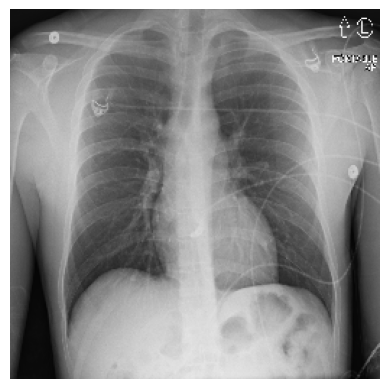

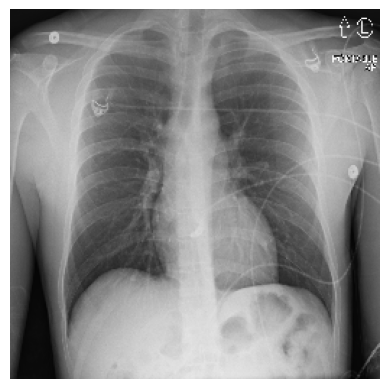

In [11]:
image_num = 65
#print(len(enhance_image_list),len(image_list))
draw_CR(apply_rotate_image(image_list[image_num],0))
draw_CR(image_list[image_num])

In [75]:
X = np.array(gaussian_image_list) 
X = X.reshape((-1, 256, 256, 1)) 
y = to_categorical(zip_list, num_classes=3)  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN

In [76]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# ResNet50

In [77]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_model(input_shape=(256, 256, 1), num_classes=3):
    # 加載ResNet50模型，不包括頂層，預設輸入尺寸為(224, 224, 3)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 凍結基模型的權重
    base_model.trainable = False

    # 建立新模型
    model = models.Sequential([
        # 因為ResNet50預設輸入尺寸為(224, 224, 3)，所以需要調整輸入圖像尺寸和通道
        layers.experimental.preprocessing.Resizing(224, 224),
        layers.Conv2D(3, (3, 3), padding='same'),  # 將圖像從1通道轉為3通道
        base_model,         
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model_ResNet50 = build_model()
model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
model_ResNet50.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))

test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

24/24 [==============================] - 19s 796ms/step - loss: 0.2726 - accuracy: 0.8987
Test accuracy: 0.8987
